<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap10/10_5_Convolution_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSCI 167 Project - CNN using CIFAR-10**

**Project Overview:** Develop a machine learning model as part of your final project for the Introduction to Deep Learning course. This project is an opportunity to demonstrate your understanding of deep learning concepts, from data exploration to model creation and evaluation. Your goal is to create one or more functional models, explore their performance, and provide meaningful analysis.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

##**Dataset Exploration**
###Dataset used: CIFAR-10

The CIFAR-10 (Canadian Institute for Advanced Research) dataset is a widely used benchmark in machine learning and computer vision tasks. It consists of 60000 32x32 color images categorized into 10 different classes: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, and Truck. Each class contains 6000 images in total, 5000 images for training, and 1000 images for testing. The images have three color channels(RGB), with pixel values ranging from 0 to 255. The dataset label distribution is balanced, with each class having the same number of images, ensuring that class imbalance does not affect model training.

The preprocessing that was applied to the CIFAR-10 dataset involves two main steps. First, the CIFAR-10 images are converted into PyTorch tensors using "transforms.ToTensor()", which scales the pixel values from the original range of [0, 255] to [0, 1]. Next, the images are normalized using "transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))", which shifts the pixel values to have a mean of 0 and a standard deviation of 1 for each RGB channel. This normalization rescales the pixel values to approximately the range of [-1, 1], which helps the model converge faster during training.

As a result, the images are transformed into tensors with the shape (batch_size, 3, 32, 32), where 3 represents the RGB channels and 32x32 is the image resolution. This preprocessing ensures that the data is in a format suitable for feeding into neural networks and helps with the stability and efficiency of training.

Other datasets explored were also CIFAR-100, which is similar to CIFAR-10 but it has 100 different classes instead of just 10. However, due to time constraints I limited myself to just CIFAR-10 for simplicity.

Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32])
torch.Size([128])


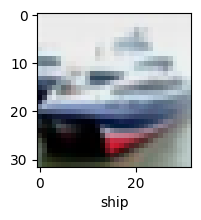

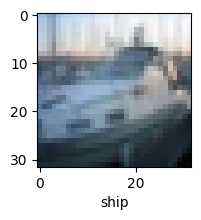

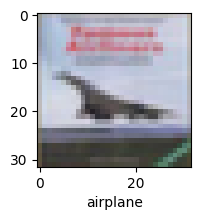

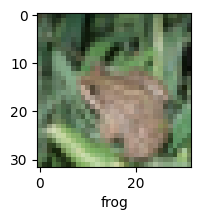

In [ ]:
# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Check the shape of the train/test data (for debug)
data_iter = iter(trainloader)
images, labels = next(data_iter)
print(images.shape)  # (batch_size, 3, 32, 32)
print(labels.shape)  # (batch_size,)

# Plot a sample from the test set
def plot_sample(X, y, index):
    plt.figure(figsize=(15, 2))

    # Denormalize the image (reverse the normalization)
    denormalized_image = X[index] / 2 + 0.5
    denormalized_image = denormalized_image.clamp(0, 1)

    # Plot the image with permuted dimensions (H, W, C)
    plt.imshow(denormalized_image.permute(1, 2, 0))
    plt.xlabel(classes[y[index]])

# Get a batch from testloader and plot the 3rd sample
sample_data_iter = iter(testloader)
images, labels = next(sample_data_iter)
# Plot 4 images from test dataset, just as example of dataset
plot_sample(images, labels, 1)
plot_sample(images, labels, 2)
plot_sample(images, labels, 3)
plot_sample(images, labels, 4)




Below are the Training and model evaluation functions, they help plot and measure the loss and performance of the model.

In [ ]:
# Training loop function
def train_model(model, trainloader, criterion, optimizer, epochs):
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(trainloader, 0):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train

        # Record the metrics for this epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print stats for this epoch
        print(f'Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    print('Finished Training')

    # Plot training loss and accuracy
    plot_training_metrics(train_losses, train_accuracies)

# Evaluate the model
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = cnn_criterion(outputs, labels)  # Calculate loss
            running_loss += loss.item()  # Add the loss for this batch to the running total
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_preds, output_dict=True, target_names=classes)

    f1 = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    # Calculate the average loss over all batches
    avg_loss = running_loss / len(testloader)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Average Loss: {avg_loss:.4f}')
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm)

    # Plot test metrics
    plot_test_metrics(accuracy, f1, precision, recall)

    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    TN = 0  # True Negatives

    # Iterate through the confusion matrix
    num_classes = cm.shape[0]
    for i in range(num_classes):
        TP += cm[i, i]  # True Positives are the diagonal elements
        FP += cm[:, i].sum() - cm[i, i]  # False Positives are the sum of the column minus the diagonal
        FN += cm[i, :].sum() - cm[i, i]  # False Negatives are the sum of the row minus the diagonal
        TN += cm.sum() - (FP + FN + TP)  # True Negatives are the total sum minus TP, FP, and FN

    # Print the results
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Negatives (TN): {TN}")

    return accuracy, f1, precision, recall

# Plot training loss and accuracy
def plot_training_metrics(train_losses, train_accuracies):
    epochs = len(train_losses)

    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

# Plot test metrics (accuracy, F1, Precision, Recall)
def plot_test_metrics(accuracy, f1, precision, recall):
    plt.figure(figsize=(10, 6))

    metrics = [accuracy, f1, precision, recall]
    labels = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

    plt.bar(labels, metrics, color=['blue', 'red', 'green', 'purple'])
    plt.ylabel('Score')
    plt.title('Test Metrics')
    plt.ylim(0, 1)
    plt.show()

# Confusion matrix plot for all classes
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

##**Model Creation**
For this project, I used a CNN(Convolutional Neural Network) because of how well known they are for image classification, as we learned in class. I had also read frequently about how CNNs are frequently used for computer vision related tasks, specifically because of how well they can extract features from images. The framework used for this project was PyTorch.

The model architecture that I ended up with was a result of many hours of training and hyperparameter changes. When I first started, I was just researching CNNs that are good for computer vision or image recognition, and I came across a PyTorch tutorial that used a CNN with the CIFAR-10 dataset for image classification called "Training a Classifier". This model had an accuracy of 60%, and I used this as a base code to play around with. The model is below, but other hyperparameters included: 2 epochs, 4 batch size, SGD for the optimizer, 0.001 for the learning rate, and 0.9 for the momentum.

    class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The tutorial itself included preprocessing steps, how to load in the training and test datasets, and how to train and test the accuracy, which I incorporated into my code in order to measure the model's performance. For the model, it had 7 layers: 2 convolution layers, 2 maxpool layers(1 after each convolution layer), and 3 fully connected layers at the end, like shown above.

After training the model for several hours, I ended up with the CNN below, which gave me an accuracy of 78%, the highest I was able to achieve. The CNN has five convolutional layers, each one followed by a batch normalization, ReLU activation, and max pooling operation. The convolutional layers all have the same kernel size of 3x3, and the amount of filters progressively doubles in each layer. The first layer starts with 3 input channels(due to the RGB channels in each image) and 32 filters(or output channels), and ends with 256 input channels(from the previous layer) and 512 filters in the 5th and final convolution layer. This increasing number of filters allows the model to capture more complex features from the input images as it keeps getting fed through the model.

After each convolution, max pooling is used to reduce the spatial dimensions of the output, this is done to make the model more computationally efficient. The model ends with two fully connected layers: the first reduces the flattened feature map to 64 units, while the second outputs 10 units, which corresponds to the 10 classes in the CIFAR-10 dataset. Batch normalization is also done after each convolution layer in order to help stabilize learning and accelerate convergence. ReLU activations are then applied to the output of batch normalization to introduce non-linearity, further enabling the network to learn complex patterns.

In [ ]:
# CNN model (Convolutional Neural Network)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional layer (input channels = 3, output channels = 32)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Batch Normalization after conv1
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional layer (input channels = 32, output channels = 64)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Batch Normalization after conv2
        self.bn2 = nn.BatchNorm2d(64)

        # Third convolutional layer (input channels = 64, output channels = 128)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Batch Normalization after conv3
        self.bn3 = nn.BatchNorm2d(128)

        # Fourth convolutional layer (input channels = 128, output channels = 256)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        # Batch Normalization after conv4
        self.bn4 = nn.BatchNorm2d(256)

        # Fifth convolutional layer (input channels = 256, output channels = 512)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        # Batch Normalization after conv5
        self.bn5 = nn.BatchNorm2d(512)

        # Max pooling layer (2x2)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layer 1
        self.fc1 = nn.Linear(512 * 1 * 1, 64)

        # Fully connected layer 2
        self.fc2 = nn.Linear(64, 10)  # 10 output classes

    def forward(self, x):
        # Apply conv1 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn1(self.conv1(x))  # BatchNorm after conv1
        x = F.relu(x)
        x = self.pool(x)

        # Apply conv2 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.pool(x)

        # Apply conv3 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn3(self.conv3(x))
        x = F.relu(x)
        x = self.pool(x)

        # Apply conv4 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn4(self.conv4(x))
        x = F.relu(x)
        x = self.pool(x)

        # Apply conv5 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn5(self.conv5(x))
        x = F.relu(x)
        x = self.pool(x)

        # Flatten the tensor to feed into the fully connected layer
        x = torch.flatten(x, 1)

        # Apply fully connected layer 1 -> ReLU
        x = F.relu(self.fc1(x))

        # Apply fully connected layer 2 -> output
        x = self.fc2(x)

        return x


# Instantiate and train the CNN model
cnn_model = CNN()
cnn_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0007)

##**Hyperparameter Exploration**
As I stated earlier, when I first started creating the model, I was just researching different CNNs and datasets, and came across a PyTorch tutorial with a starter CNN that had 60% accuracy. I used this as my base code, and started building onto it to increase its performance.

One of the first things I explored was the impact of the learning rate and momentum on the model. While I was able to minimize the loss during training by adjusting these variables several times, it did not have much of an impact on actual performance, accuracy only increased by 1-2%. After this, I figured I had to start making more drastic changes in order to see a big increase in performance, so I changed the epochs to 20 since I thought maybe the model had to train for longer of the training data to have better performance. I also changed the optimizer from SGD(Stochastic Gradient Descent) to Adam(Adaptive Moment Estimation) because of Adam's ability to adapt the learning rate for each parameter individually. These changes also did not have an impact on performance, but I left it because I figured its better to update values during training as opposed to having a static learning rate.

From here, I moved on to changing the architecture of the network in order to improve the performance more drastically. I first started with editing the number of filters being passed through the network. I tried starting with huge numbers first, with my first layer having 128 outputs, and the 2nd layer having 256, but this only dropped my performance under 60%. After much research, I found a common theme where a lot of CNNs increasingly double their filters in each layer, so I chose to try this method out. The first layer had 32 outputs, and the 2nd had 64 outputs. I also edited the batch size to 128 in order to speed up the training process. This change in my code gave me a huge boost in performance, from 60% to 70%.

Once I achieved this boost, I thought it would be wise to leave the filters as is, and instead start increasing the number of layers to capture more complex features, like in the AlexNet model we talked about during class, which has 5 convolution layers but uses a different dataset with larger images. I started by adding 2 convolution layers, with the same increasing filter pattern. Now I had 256 output channels at the end of the 4th convolution layer. I also changed the epochs to 30 since the network was now deeper; however, after futher testing, I discorvered that the same results can be achieved with 20 epochs. After testing these changes, accuracy increased to 75%. Further alteration of the learning rate was able to achieve 76% accuracy. I added 1 more layer after this to see if that would further improve performance, but it stayed at 76% after this change. The most notable change was that the training time was now taking 2 hours every round.

Further research enabled me to be able to apply batch normalization to the model. Batch Normalization is used to improve the performance and stability of artificial neural networks by normalizing the activations of the layers within the network. This helps with issues like vanishing/exploding gradients which make the model harder to train effectively. Batch Normalization helps to avoid these issues by stabilizing the learning process. I applied batch normalization to every convolutional layer in the model, and after testing, the model's performance increased to 78%. I did attempt to change the learning rate and other hyperparams like the filters to further improve the model, but due to time constraints, 78% accuracy was the best performance I was able to achieve.

Epoch 1/20 - Loss: 1.1408, Train Accuracy: 58.94%
Epoch 2/20 - Loss: 0.7491, Train Accuracy: 73.75%
Epoch 3/20 - Loss: 0.5918, Train Accuracy: 79.28%
Epoch 4/20 - Loss: 0.4778, Train Accuracy: 83.32%
Epoch 5/20 - Loss: 0.3858, Train Accuracy: 86.58%
Epoch 6/20 - Loss: 0.2907, Train Accuracy: 89.78%
Epoch 7/20 - Loss: 0.2227, Train Accuracy: 92.20%
Epoch 8/20 - Loss: 0.1730, Train Accuracy: 94.00%
Epoch 9/20 - Loss: 0.1354, Train Accuracy: 95.18%
Epoch 10/20 - Loss: 0.1069, Train Accuracy: 96.31%
Epoch 11/20 - Loss: 0.0961, Train Accuracy: 96.61%
Epoch 12/20 - Loss: 0.0805, Train Accuracy: 97.22%
Epoch 13/20 - Loss: 0.0791, Train Accuracy: 97.28%
Epoch 14/20 - Loss: 0.0680, Train Accuracy: 97.50%
Epoch 15/20 - Loss: 0.0685, Train Accuracy: 97.57%
Epoch 16/20 - Loss: 0.0490, Train Accuracy: 98.27%
Epoch 17/20 - Loss: 0.0569, Train Accuracy: 98.01%
Epoch 18/20 - Loss: 0.0571, Train Accuracy: 98.01%
Epoch 19/20 - Loss: 0.0464, Train Accuracy: 98.41%
Epoch 20/20 - Loss: 0.0465, Train Accura

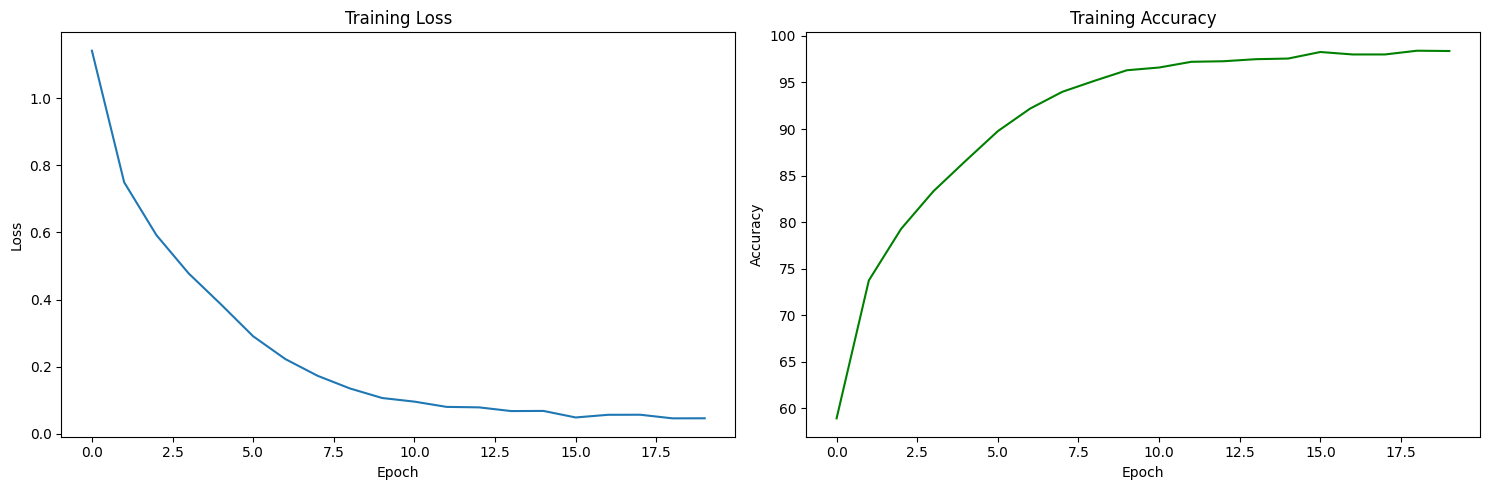

Test Accuracy: 78.54%
Average Loss: 1.2016
Classification Report:
               precision    recall  f1-score   support

    airplane       0.81      0.83      0.82      1000
  automobile       0.89      0.90      0.90      1000
        bird       0.77      0.69      0.73      1000
         cat       0.54      0.74      0.63      1000
        deer       0.88      0.62      0.73      1000
         dog       0.71      0.65      0.68      1000
        frog       0.83      0.85      0.84      1000
       horse       0.82      0.81      0.82      1000
        ship       0.86      0.88      0.87      1000
       truck       0.85      0.88      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



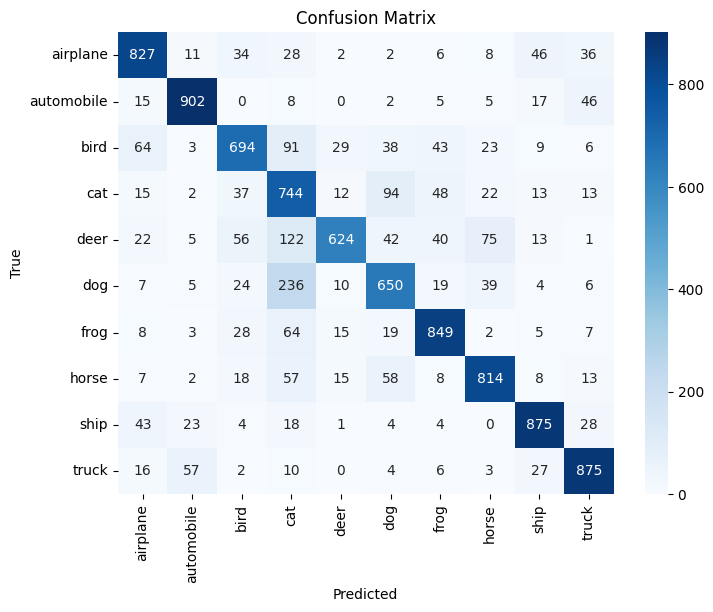

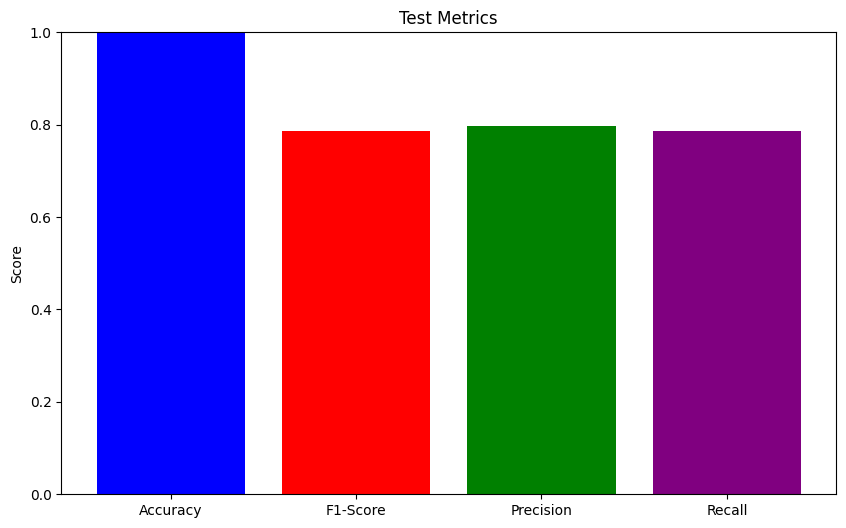

True Positives (TP): 7854
False Positives (FP): 2146
False Negatives (FN): 2146
True Negatives (TN): 32463


(78.54, 0.7854, 0.7961271519315339, 0.7854)

In [ ]:
# Train the CNN model
train_model(cnn_model, trainloader, cnn_criterion, optimizer, epochs=20)
# Test the CNN model
evaluate_model(cnn_model, testloader)

##**Results**

The final model's performance was a huge improvement from where I started. The starter CNN I used had 60% accuracy on the CIFAR-10 dataset, and the CNN that I ended with had peaked at 78% accuracy.

Beyond this, lets take a look at the training phase of the model. In the graphs above, we can see the Training Loss and Accuracy printed out per epoch, and graphed over each epoch. As we can see, the loss was essentially minimized, meaning that the model was learning from the training data effectively. The training accuracy also increased to 98% over the training session. This was achieved through rigorous training and fine-tuning of the hyperparameters for the model, specfically the learning rate has a huge impact on this. The graphs also helped me to discover that I could reduce my epochs from 30 to 20 without negatively impacting its performance.

Let us now take a look at the testing/evaluation stage of the model. As we can also see above(below the training data), the model achieved an accuracy of 78% on the entire test dataset. Along with the accuracy, we also recieve the recall, f1-score, and precision of the model, which are other metrics to help measure the models performance. Precision checks how many of the positive predictions are really correct, showing the rate of true positives among total positives. Recall tells you how many of the actual positive cases were identified correctly, which is the rate of true positives over true positives plus false negatives. Finally, the f1-score is used to balance the trade-off between precision and recall, specifically when there is imbalance in the label distribution of the dataset being used, which does not apply to this since CIFAR-10 was used. The precision for the model was an average of 0.8, the recall was 0.79, and the f1-score also had an average of 0.79(similar to precision and recall since the dataset is already evenly distributed). These metrics are also available for each class up above.

The confusion matrix above is also a great way to observe the performance of the model. It shows us how many times each class was correctly predicted(when the class prediction matches the true class value in the matrix), and also the amount of times it predicted incorrectly. The confusion matrix does not show specifically how many times the model predicted incorrectly, but it does show all the classes and the number of times that the model incorrectly guessed each respective class.

This model could definately go through some improvement, especially since I was able to find other CNNs using the same dataset but with higher accuracy. One of the areas of the model that I did not play around with too much are the number of output channels(filters) in each convolution layer. Im afraid that my intuition in this area is very poor, most times when I changed the number of output channels in the convolution layers, it would give me worse performance. That is why when I found a pattern of filters that worked, I stayed with it and decided not to change this further. Similarly, the size of the kernel in each layer was not tampered with too much. I went through something similar where my intuition in this area is not great, so I did not want to change this hyperparameter too much either to avoid wasting time. Ultimately, if I had more time, these are the areas that I would explore next to see if I could better the performance.

Below is a demonstration of the model, using 5 sample images from the test dataset.

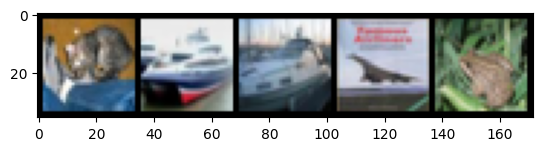

GroundTruth:  cat   ship  ship  airplane frog 
Predicted:  cat   ship  cat   airplane frog 


In [ ]:
# Demonstration of Model
cnn_model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)

# Select the first 5 images and labels from the batch
images = images[:5]
labels = labels[:5]

# Normalize images back to the range [0, 1]
images = images / 2 + 0.5  # Denormalize CIFAR-10 images

# Create a grid of the first 5 images
image_grid = torchvision.utils.make_grid(images)

# Convert the grid to a numpy array and permute from (C, H, W) to (H, W, C)
image_grid = image_grid.permute(1, 2, 0).cpu().numpy()

# Display the image grid
plt.imshow(image_grid)
plt.show()

# Print the ground truth labels (the actual classes) for the first 5 images
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

# Get the model's predictions for the first 5 images
outputs = cnn_model(images)  # Forward pass to get model predictions
_, predicted = torch.max(outputs, 1)

# Print the predicted labels for the first 5 images
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(5)))